## Goal
Predict The cost/watt for typical residential solar installation in 4-6 quarters past the end of my data.


## Data and Features Research
   


<b>Feed-In Tariff</b> is a policy mechanism designed to accelerate investment in renewable energy technologies. It achieves this by offering long-term contracts to renewable energy producers typically based on the cost of generation of each technology.<br>

<b>Azimuth</b>/ <b>Tilt</b> PV panel orientation (azimuth and tilt) is a key determinant of PV energy production. typically oriented due south and with tilt equal to the location’s latitude. 

<b>BIPV Module</b><br>

<b>DC Optimizer</b><br>

<b>Ground Mounted</b><br>

<b>Inverter Loading Ratio</b><br>

<b>Inverter Model</b><br>

<b>Microinverter</b><br>

<b>Module Efficiency</b><br>

<b>Module Technology </b><br>

<b>New Construction</b><br>

<b>Performance-Based Incentive</b><br>

<b>Rebate or Grant</b><br>

<b>Sales Tax Cost</b><br>

<b>Self-Installed</b><br>

<b>System Inverter Capacity</b><br>

<b>System Size</b><br>

<b>Third-Party Owned</b></b> - TPO comprising just 38% of the full
residential sample in 2018<br>

<b>Total Installed Price</b><br>

<b>Tracking</b><br>

<b>Battery</b> - Pairing battery storage with distributed PV has become more common, as storage costs decline,
as customers with high reliability needs seek to ride-through outages, and as utilities adopt
incentives and implement rate designs that encourage storage adoption.

<b>-9999</b> - used in place of nulls

In [2]:
import random
import os
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#sns.palplot(sns.color_palette("Set2"))
import plotly.express as px

import _pickle as pickle
import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import datetime
from dateutil.parser import parse

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV,  KFold
from sklearn.metrics import f1_score, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import helpers
from helpers import time_series_me, residual_plot


plt.style.use('ggplot')

In [3]:
dfMod1 = pd.read_csv('/Users/jenniferpaige/Downloads/tts_lbnl_public_data_file_10-dec-2019_0/TTS_LBNL_public_file_10-Dec-2019_p1.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue,
                    parse_dates=['Installation Date'])

dfMod2 = pd.read_csv('/Users/jenniferpaige/Downloads/tts_lbnl_public_data_file_10-dec-2019_0/TTS_LBNL_public_file_10-Dec-2019_p2.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue,
                    parse_dates=['Installation Date'])

odfMod = pd.concat([dfMod1, dfMod2], ignore_index=True)

In [4]:
dfMod = odfMod.copy()

In [4]:
dfMod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543831 entries, 0 to 1543830
Data columns (total 60 columns):
Data Provider                                           1543831 non-null object
System ID (from first Data Provider)                    1543831 non-null object
System ID (from second Data Provider, if applicable)    1543831 non-null object
System ID (Tracking the Sun)                            1543831 non-null object
Installation Date                                       1543831 non-null datetime64[ns]
System Size                                             1543831 non-null float64
Total Installed Price                                   1543831 non-null float64
Appraised Value Flag                                    1543831 non-null bool
Sales Tax Cost                                          1543831 non-null float64
Rebate or Grant                                         1543831 non-null float64
Performance-Based Incentive (Annual Payment)            1543831 non-null floa

In [13]:
dfMod['State'].nunique()

28

In [14]:
# create year month columns
month = dfMod['Installation Date'].apply(lambda x: x.to_period('M'))
year = dfMod['Installation Date'].apply(lambda x: x.to_period('Y'))

dfMod = dfMod.assign(Install_Month=month)
dfMod = dfMod.assign(Install_Year=year)

In [6]:
#only residential
rdfMod = dfMod[dfMod['Customer Segment'] == 'RES']
print(len(rdfMod))

1456225


In [7]:
# # appraised values are not market prices, going to ignore
# rdfMod = rdfMod[rdfMod['Appraised Value Flag'] == False]
# print(len(rdfMod))

1068342


Text(0, 0.5, 'Number of Installations')

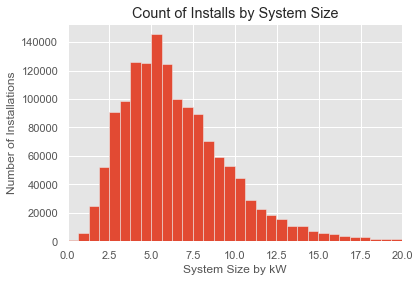

In [10]:
plt.hist(rdfMod['System Size'], bins=8000)
plt.xlim(0,20)
plt.title('Count of Installs by System Size')
plt.xlabel('System Size by kW')
plt.ylabel('Number of Installations')

In [9]:
#get further insight into system sizes
rdfMod[['System Size']].describe()

,System Size
count,1.068342e+06
mean,6.727776e+00
std,1.058624e+01
min,3.150000e-03
25%,4.160000e+00
50%,5.940000e+00
75%,8.265000e+00
max,4.990000e+03


In [16]:
#removing systems greater than 40kW in size given they are outside of the norm
rdfMod = rdfMod[rdfMod['System Size'] < 30]
print(len(rdfMod))

1065999


In [1]:
pwd

'/Users/jenniferpaige/getit/capstone_try'

In [17]:
#See a count of installations by state
rdfMod.State.value_counts()

CA    644104
AZ     85095
NJ     71713
NY     63826
MA     48571
CO     31206
TX     21306
UT     19575
NM     16190
MD     11297
VT      9544
CT      8727
PA      6338
NH      4933
MO      4710
DC      3707
OR      3492
WI      3171
FL      2430
DE      2229
MN      1444
OH      1284
RI       881
KS       134
AR        92
Name: State, dtype: int64

In [18]:
#count of installations in top ten states
rdfMod.State.map(lambda x: x in ['CA', 'AZ', 'NJ','NY', 'MA', 'CO', 'TX', 'UT', 'NM','MD']).sum()

1012883

In [19]:
#percent that top ten state installations make up of full data
_/len(rdfMod)

0.950172561137487

In [21]:
rdfMod.sort_values('Installation Date', inplace=True)

In [22]:
rdfMod.reset_index(inplace=True, drop=True)

In [23]:
#obtain Total Installed Price column means per year

for i in rdfMod['Installation Date'].dt.year.unique():
    print(round(rdfMod.loc[(rdfMod['Installation Date'].dt.year == i)&(rdfMod['Total Installed Price']!= -9999)&(rdfMod['Total Installed Price']!= '-9999')]['Total Installed Price'].mean(),2))

16858.89
21992.1
24080.14
28295.34
31983.51
37532.2
34147.49
37335.41
39483.21
41533.98
40613.3
40477.49
38830.23
34937.41
31230.95
29931.95
27727.34
26076.1
55840.74
27661.03
26640.9


In [24]:
# indices where each year begins in the data 
inds = [0,
24,
197, 
378, 
1591,
3854,
6832,
11827,
16973,
25492,
37983,
51990,
77252,
113118,
158121,
214674,
289163,
390140,
536852,
722062,
888391]

In [25]:
# replace nulls with mean

rdfMod['Total Installed Price'][:24].replace([-9999], 16858.89,regex=True, inplace=True)
rdfMod['Total Installed Price'][24:197].replace([-9999], 25196.26,regex=True, inplace=True)
rdfMod['Total Installed Price'][197:378].replace([-9999],24080.14 ,regex=True, inplace=True)
rdfMod['Total Installed Price'][378:1591].replace([-9999],28678.69 ,regex=True, inplace=True)
rdfMod['Total Installed Price'][1591:3854].replace([-9999], 32159.65,regex=True, inplace=True)
rdfMod['Total Installed Price'][3854:6832].replace([-9999], 37653.06,regex=True, inplace=True)
rdfMod['Total Installed Price'][6832:11827].replace([-9999],34520.98 ,regex=True, inplace=True)
rdfMod['Total Installed Price'][11827:16973].replace([-9999], 38743.84,regex=True, inplace=True)
rdfMod['Total Installed Price'][16973:25492].replace([-9999], 40592.27,regex=True, inplace=True)
rdfMod['Total Installed Price'][25492:37983].replace([-9999], 42770.71,regex=True, inplace=True)
rdfMod['Total Installed Price'][37983:51990].replace([-9999], 41116.92,regex=True, inplace=True)
rdfMod['Total Installed Price'][51990:77252].replace([-9999], 40741.36,regex=True, inplace=True)
rdfMod['Total Installed Price'][77252:113118].replace([-9999], 39006.21,regex=True, inplace=True)
rdfMod['Total Installed Price'][113118:158121].replace([-9999], 35078.57,regex=True, inplace=True)
rdfMod['Total Installed Price'][158121:214674].replace([-9999], 31342.95,regex=True, inplace=True)
rdfMod['Total Installed Price'][214674:289163].replace([-9999], 30040.8,regex=True, inplace=True)
rdfMod['Total Installed Price'][289163:390140].replace([-9999], 27824.42,regex=True, inplace=True)
rdfMod['Total Installed Price'][390140:536852].replace([-9999], 26122.85,regex=True, inplace=True)
rdfMod['Total Installed Price'][536852:722062].replace([-9999], 55891.14,regex=True, inplace=True)
rdfMod['Total Installed Price'][722062:888391].replace([-9999], 27711.49,regex=True, inplace=True)
rdfMod['Total Installed Price'][888391:].replace([-9999], 26702.52,regex=True, inplace=True)


In [26]:
# add number of days column to show days since first observation
# can use in assisting with time series
rdfMod['Num of Days']  = rdfMod['Installation Date'] - rdfMod['Installation Date'][0]

#make integer only values
rdfMod['Num of Days'] = rdfMod['Num of Days'].dt.days

In [27]:
#now that nulls have been taken care of
# Create column which calculates the price per watt to use as target
rdfMod['Price per Watt'] = round(rdfMod['Total Installed Price']/ rdfMod['System Size']/1000,2) 

In [28]:
# look for crazy outliers
sorted(rdfMod['Price per Watt'].unique(), reverse=True)

[671779.87,
 41666.67,
 29553.69,
 9299.85,
 7142.86,
 6666.67,
 3760.91,
 1918.5,
 1286.55,
 1075.81,
 926.91,
 823.84,
 782.41,
 668.45,
 656.13,
 578.3,
 549.51,
 548.32,
 533.56,
 529.0,
 528.99,
 523.08,
 515.86,
 505.75,
 480.0,
 478.1,
 477.0,
 468.92,
 463.75,
 440.51,
 427.67,
 406.01,
 401.11,
 399.0,
 395.25,
 380.0,
 373.46,
 370.51,
 366.75,
 364.26,
 359.71,
 354.23,
 350.0,
 348.0,
 346.28,
 345.72,
 345.01,
 344.89,
 342.64,
 335.5,
 332.61,
 326.84,
 324.5,
 324.26,
 323.5,
 321.0,
 319.02,
 315.0,
 314.06,
 313.0,
 309.5,
 308.15,
 307.0,
 306.0,
 302.82,
 301.93,
 301.0,
 299.0,
 297.5,
 297.34,
 295.5,
 293.69,
 292.32,
 292.0,
 291.38,
 289.5,
 288.5,
 283.2,
 282.76,
 280.3,
 272.81,
 271.0,
 265.74,
 257.0,
 256.39,
 241.9,
 237.78,
 207.0,
 205.58,
 205.4,
 203.71,
 203.24,
 201.5,
 199.61,
 197.84,
 196.11,
 192.31,
 186.3,
 185.74,
 185.19,
 183.27,
 182.0,
 181.9,
 178.21,
 177.43,
 176.62,
 175.34,
 174.66,
 172.85,
 168.62,
 168.59,
 168.0,
 166.67,
 163.31

In [29]:
#get rid of outliers (~1000 where price per W > $50)
rdfMod = rdfMod.loc[rdfMod['Price per Watt'] < 50]

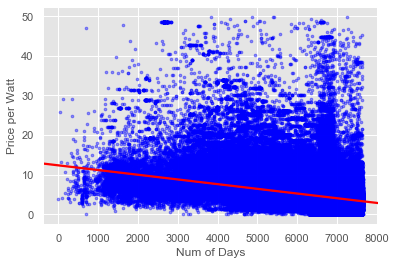

In [30]:
sns.regplot('Num of Days', 'Price per Watt', rdfMod, 
          scatter_kws={'alpha' : 0.4, 's' : 7, 'color':'blue'},
          line_kws={'color' : 'red'} , label= {'Number of days vs price per watt'})

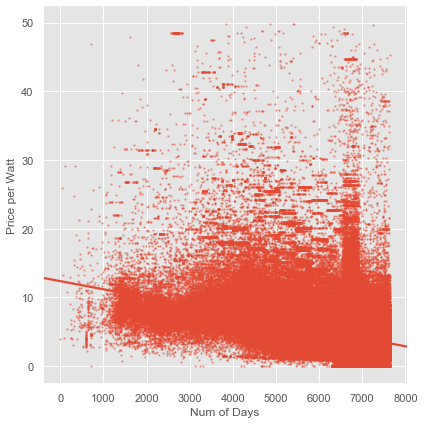

In [31]:
sns.lmplot('Num of Days', 'Price per Watt', rdfMod, 
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

In [32]:
#save current dataset
rdfMod.to_csv('/Users/jenniferpaige/DSI/renewable_energy/ModelData.csv')

KeyboardInterrupt: 

In [33]:
rdfMod['System Size'].max()

29.99919388

In [37]:
scaleSize = rdfMod['System Size']/3
scaleSize = scaleSize.astype(np.int)
rdfMod = rdfMod.assign(scaleSize = scaleSize)

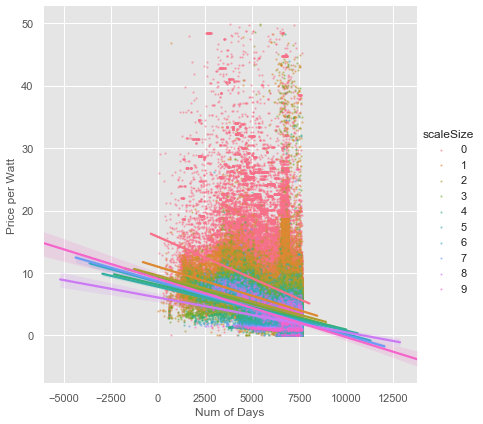

In [38]:
sns.lmplot('Num of Days', 'Price per Watt', rdfMod, 
           hue = 'scaleSize',
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

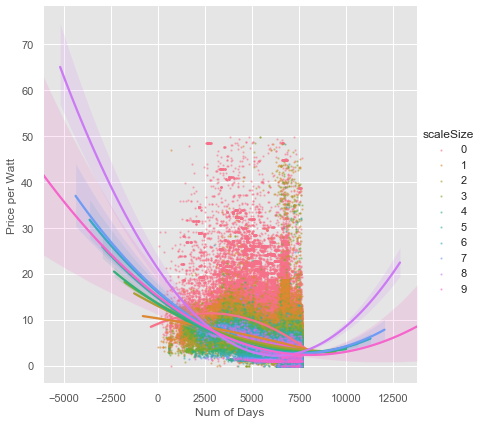

In [39]:
# quadratic
sns.lmplot('Num of Days', 'Price per Watt', rdfMod, 
           hue = 'scaleSize', order=2,
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

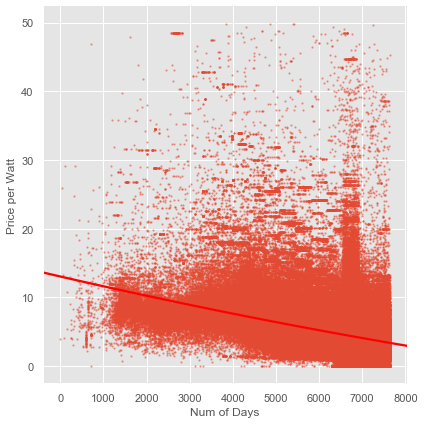

In [40]:
# quadratic
sns.lmplot('Num of Days', 'Price per Watt', rdfMod, 
           order=2,
           size=6, markers='.', 
           scatter_kws={'alpha' : 0.4, 's' : 7},
           line_kws={'color' : 'red'} )

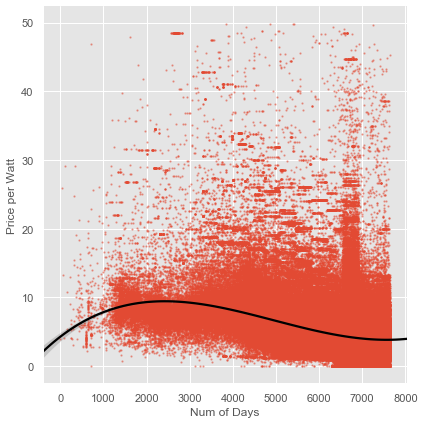

In [41]:
# 4th degree polynomial
sns.lmplot('Num of Days', 'Price per Watt', rdfMod,
           order=4,
           size=6, markers='.',
           scatter_kws={'alpha' : 0.4, 's' : 7},
           line_kws={'color' : 'black'} )

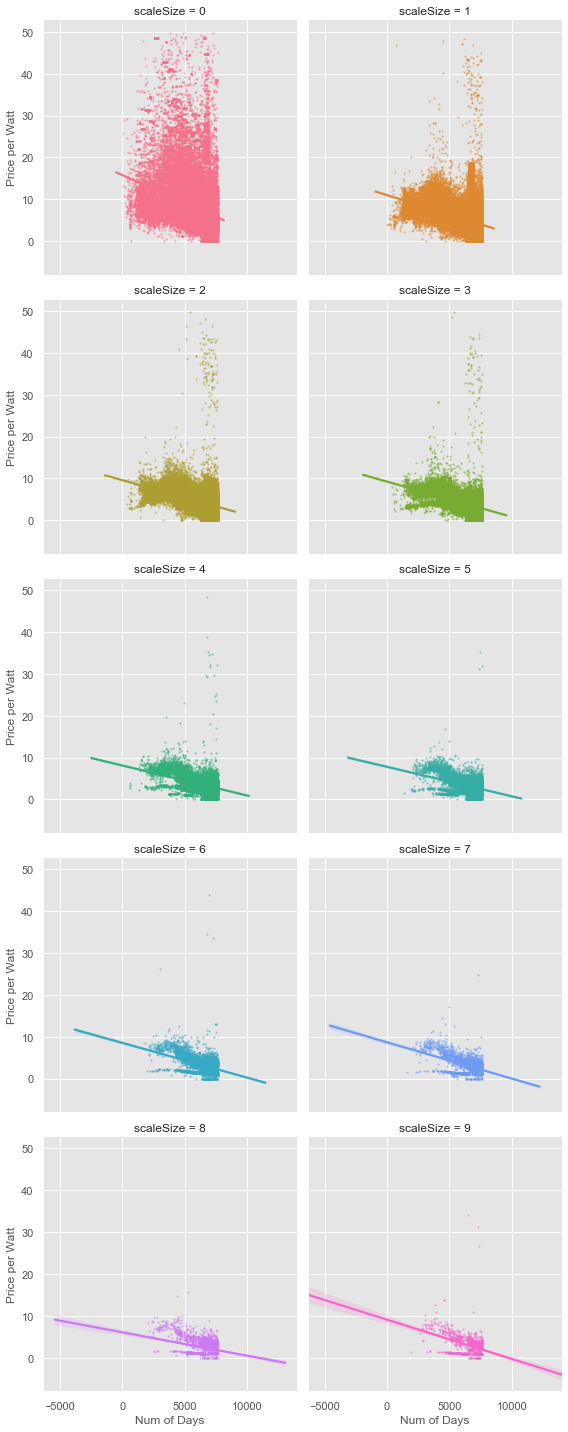

In [42]:
sns.lmplot('Num of Days', 'Price per Watt', rdfMod,
           hue = 'scaleSize', col='scaleSize', col_wrap=2,
           size=4, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})


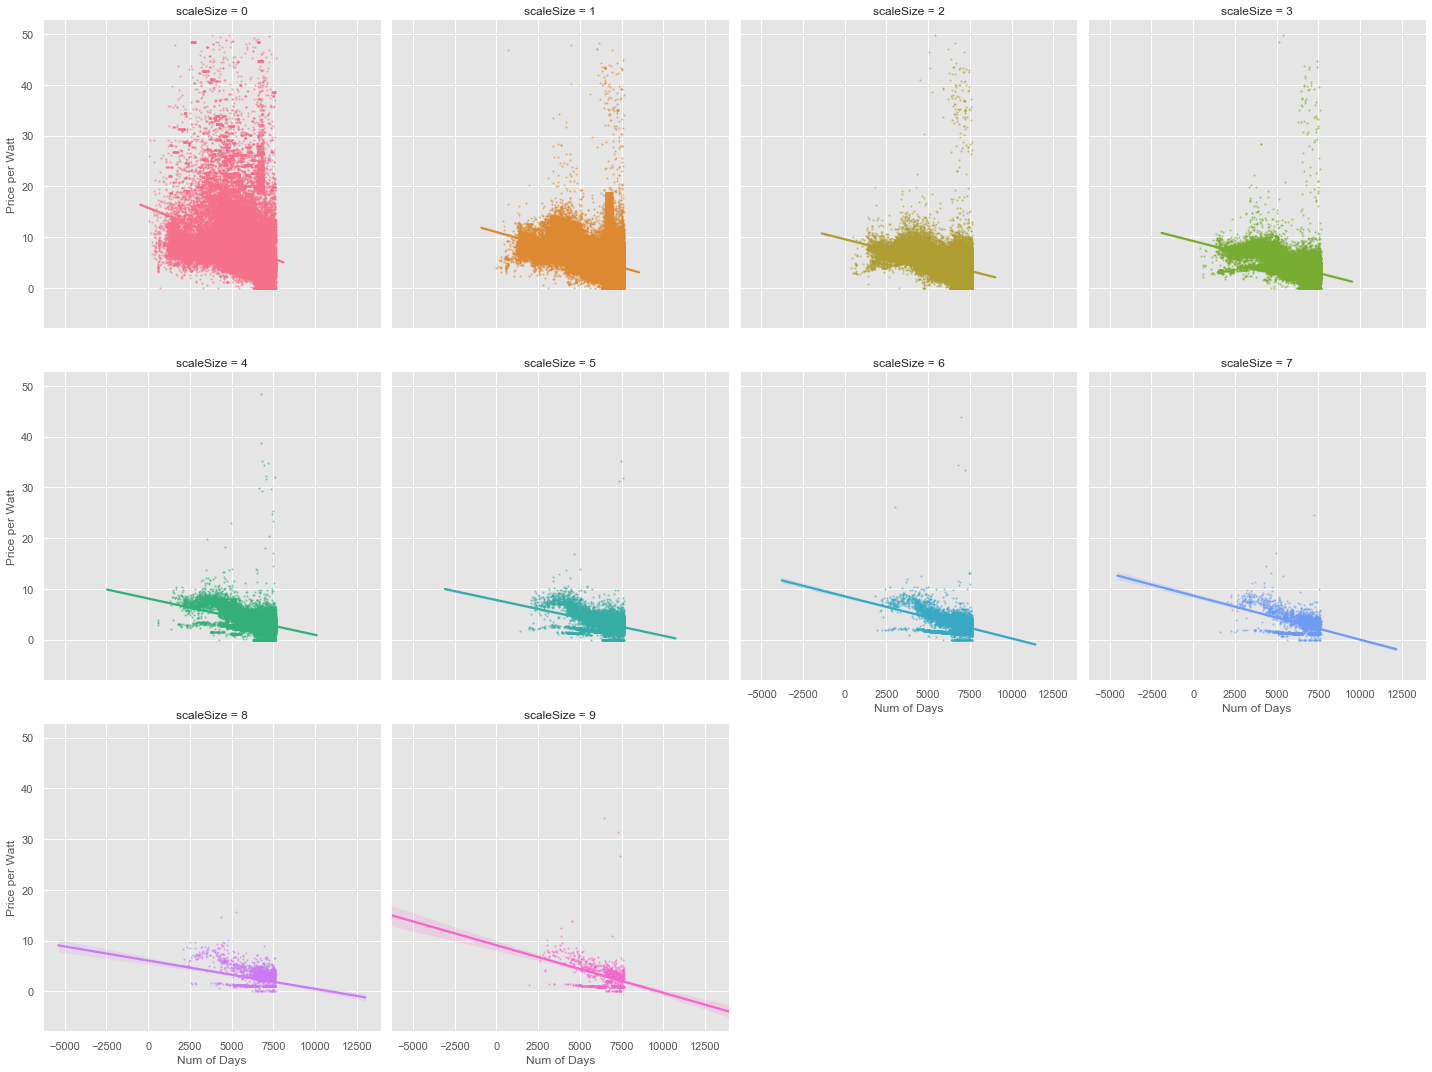

In [43]:
sns.lmplot('Num of Days', 'Price per Watt', rdfMod, 
           hue = 'scaleSize', col='scaleSize', col_wrap=4,
           size=5, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

#### linear regression

In [44]:
rdfmod = rdfMod.copy()

In [45]:
rdfmod = rdfmod[['Installation Date','System Size','Total Installed Price','State', 'Install_Month','Install_Year','Num of Days','Price per Watt','scaleSize' ]]

In [46]:
rdfmod.columns = rdfmod.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [47]:
m0 = ols('price_per_watt ~ num_of_days', rdfmod).fit()
print(m0.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                 2.511e+05
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:01:31   Log-Likelihood:            -2.5935e+06
No. Observations:             1065426   AIC:                         5.187e+06
Df Residuals:                 1065424   BIC:                         5.187e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3701      0.015    823.864      

In [48]:
m1 = ols('price_per_watt ~ num_of_days + system_size', rdfmod).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 2.021e+05
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:01:31   Log-Likelihood:            -2.5349e+06
No. Observations:             1065426   AIC:                         5.070e+06
Df Residuals:                 1065423   BIC:                         5.070e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.2260      0.014    917.327      

In [49]:
m2 = ols('price_per_watt ~ num_of_days + system_size +C(state)', rdfmod).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 1.680e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:01:36   Log-Likelihood:            -2.5231e+06
No. Observations:             1065426   AIC:                         5.046e+06
Df Residuals:                 1065399   BIC:                         5.047e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.2427      0.270     49.

In [50]:
mQuad2 = ols('price_per_watt~ num_of_days + system_size + num_of_days*num_of_days + num_of_days**2 + system_size**2', rdfmod).fit()
print(mQuad2.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 2.021e+05
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:01:37   Log-Likelihood:            -2.5349e+06
No. Observations:             1065426   AIC:                         5.070e+06
Df Residuals:                 1065423   BIC:                         5.070e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.2260      0.014    917.327      

In [51]:
mQuad2wState = ols('price_per_watt ~num_of_days + system_size+C(state)+num_of_days*system_size+num_of_days**2+system_size**2', rdfmod).fit()
print(mQuad2wState.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                 1.701e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:01:42   Log-Likelihood:            -2.5153e+06
No. Observations:             1065426   AIC:                         5.031e+06
Df Residuals:                 1065398   BIC:                         5.031e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [52]:
X = rdfmod.num_of_days.values.reshape(-1, 1)
y = rdfmod.price_per_watt.values.reshape(-1, 1)

In [53]:
reg = LinearRegression()

In [54]:
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

In [55]:
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
y_pred = reg.predict(prediction_space)

In [57]:
print(reg.score(X,y))

0.1907267482902436


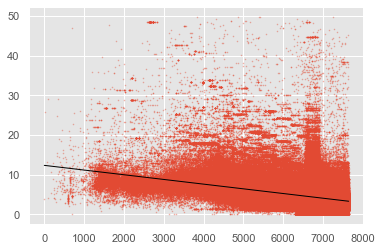

In [58]:
plt.scatter(X, y, marker='.', s=5, alpha=0.3)
plt.plot(prediction_space, y_pred, color='black', linewidth=1)
plt.show()

[[-0.00118371]] [12.36815762]
R^2: 0.19134023294779345
Root Mean Squared Error (test): 2.757877550192111
Root Mean Squared Error (train): 2.760639438056997


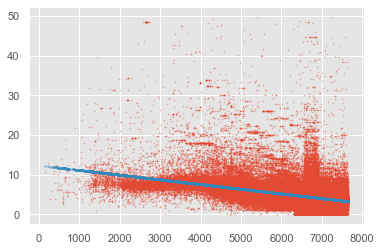

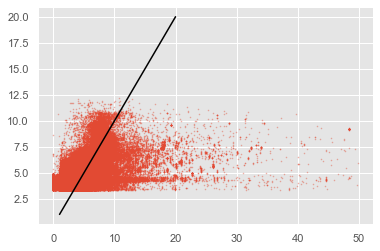

In [59]:
# for now stick with 1 feature

X = rdfmod[['num_of_days']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], y_pred, s=4, alpha=0.5)
plt.show();
# actual and predicted vs X
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='black')
plt.show()

[[ 0.00000000e+00 -1.43631606e-03  2.32506081e-08]] [13.0042271]
R^2: 0.19249677257704145
Root Mean Squared Error (test): 2.777589427371698
Root Mean Squared Error (train): 2.7552337211599838


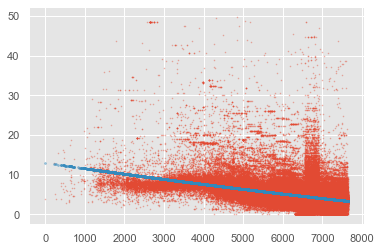

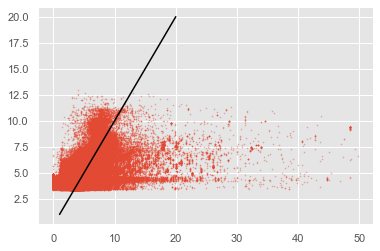

In [60]:
Xraw = rdfmod[['num_of_days']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

# actual and predicted vs X
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='black')
plt.show()

[[ 0.00000000e+00  4.52088113e-03 -1.23581034e-06  8.27253535e-11]] [4.54867033]
R^2: 0.1998830922944027
Root Mean Squared Error (test): 2.743271460274303
Root Mean Squared Error (train): 2.7464349046472663


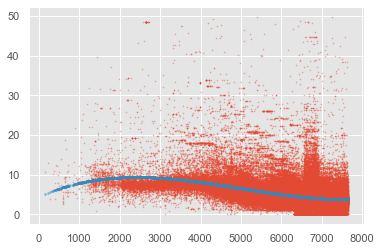

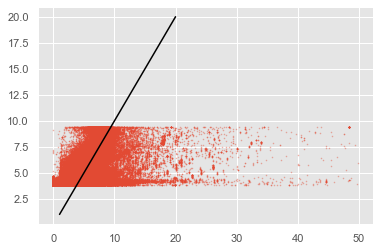

In [61]:
#cubic

Xraw = rdfmod[['num_of_days']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='black')
plt.show()

[[ 0.00000000e+00  4.79639034e-03 -1.33464466e-06  9.71904395e-11
  -7.45931095e-16]] [4.29521725]
R^2: 0.19988682062694785
Root Mean Squared Error (test): 2.743265068808205
Root Mean Squared Error (train): 2.746431327395294


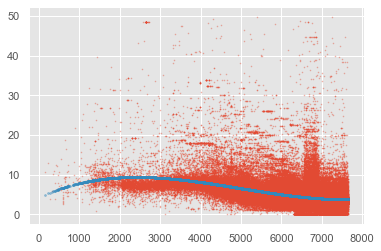

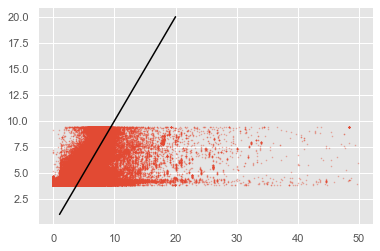

In [62]:
# 1 feature, degree 4 model
Xraw = rdfmod[['num_of_days']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=4)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='black')
plt.show()

[[ 0.00000000e+00  2.70091864e-09  1.87140227e-06 -7.96876152e-10
   1.10308461e-13 -5.08476608e-18]] [6.32710193]
R^2: 0.20005362522586914
Root Mean Squared Error (test): 2.7415256210421064
Root Mean Squared Error (train): 2.7444151278035465


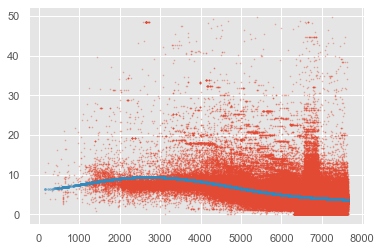

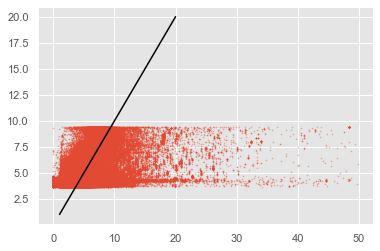

In [63]:
# 1 feature, degree 4 model
Xraw = rdfmod[['num_of_days']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=5)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='black')
plt.show()

#### adding in system_size

R^2: 0.277403182594849
Root Mean Squared Error: 2.627507347914127


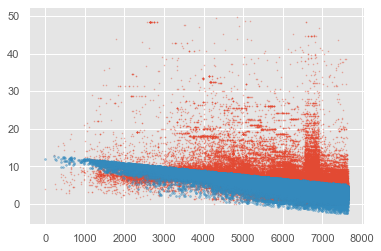

In [64]:
# features: num_of_days and system_size

X = rdfmod[['num_of_days', 'system_size']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.3115398774341551
Root Mean Squared Error: 2.5446699211140746
[[ 0.00000000e+00 -1.08669780e-03 -1.08596579e+00 -2.56120147e-08
   6.77956695e-05  2.14356168e-02]] [15.91244616]


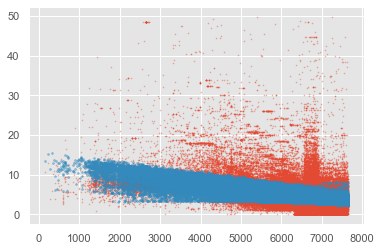

In [65]:
# features: num_of_days and system_size, but go poly, ax**2 + b*x + c

Xraw = rdfmod[['num_of_days', 'system_size']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.34009794195028153
Root Mean Squared Error: 2.4913331269171715
[[ 0.00000000e+00  4.81483580e-03 -1.82878777e+00 -1.14937688e-06
  -7.21501464e-05  1.45408914e-01  6.44815581e-11  2.30232945e-08
  -7.75295283e-06 -2.16160272e-03]] [8.81136191]


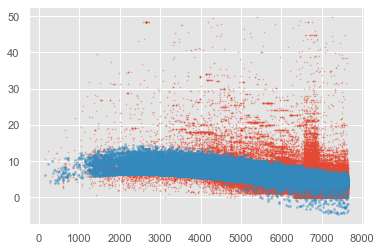

In [66]:
#3rd degree
Xraw = rdfmod[['num_of_days', 'system_size']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.34907140929744795
Root Mean Squared Error: 2.474336348959881
[[ 0.00000000e+00  9.13888835e-03  1.34425472e-02 -1.71680235e-06
  -1.46687853e-03  2.61553477e-01  8.27950054e-11  2.18701769e-07
   2.62514867e-05 -1.51421551e-02  1.09287579e-16 -7.24494061e-12
  -4.20304998e-09  4.63877643e-07  2.01340444e-04]] [1.15474798]


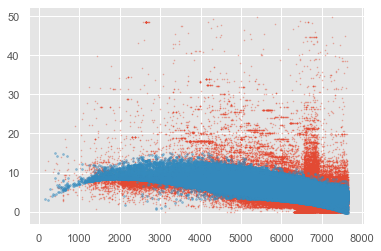

In [67]:
#4th degree
Xraw = rdfmod[['num_of_days', 'system_size']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=4)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.34611079701529757
Root Mean Squared Error: 2.4799569653345
[[ 0.00000000e+00  3.38150824e-08  2.16811760e-09  2.52855024e-06
   2.30255197e-06  5.46561216e-08 -7.66946838e-10 -3.91219052e-07
   7.36385727e-05  6.05445144e-07  8.07870466e-14  7.60896009e-11
  -1.93981516e-09 -3.05008466e-06  3.74617404e-06 -3.03385659e-18
  -3.70236721e-15 -5.60395263e-13  2.07993488e-10  2.51022439e-08
   2.93630633e-07]] [5.71436832]


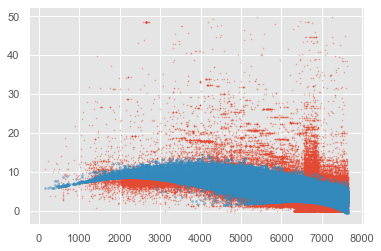

In [68]:
#5th degree
Xraw = rdfmod[['num_of_days', 'system_size']].values
y = rdfmod.price_per_watt.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=5)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.20, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

In [69]:
dfModSt = pd.get_dummies(rdfmod, drop_first=True)

In [70]:
X = dfModSt.drop(['scalesize', 'price_per_watt', 'installation_date'], axis='columns').values
y = dfModSt.price_per_watt.values.reshape(-1, 1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

TypeError: float() argument must be a string or a number, not 'Period'

In [72]:
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.2)
plt.show();

TypeError: float() argument must be a string or a number, not 'Period'

In [73]:
np.random.shuffle(X)

In [74]:
reg = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[nan nan nan nan nan]
Average 5-Fold CV Score: nan


In [75]:
Epoch = rdfmod.iloc[0]['installation_date']; Epoch

Timestamp('1998-01-30 00:00:00')

In [76]:
Epoch.year, Epoch.month, Epoch.day

(1998, 1, 30)

In [77]:
MedByDay = rdfmod.groupby(['num_of_days', 'scalesize', 'state'])['price_per_watt'].median()


In [78]:
thing = MedByDay.reset_index();thing.head()

,num_of_days,scalesize,state,price_per_watt
0,0,1,CA,3.97
1,30,0,NM,25.94
2,68,0,CA,13.27
3,90,1,CA,4.03
4,102,0,OR,29.06


In [79]:
dfMedByDay = thing

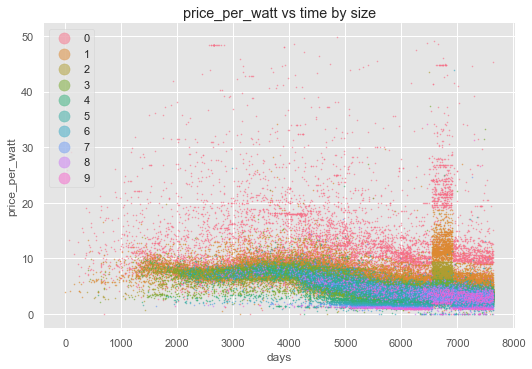

In [80]:
g = sns.FacetGrid(dfMedByDay, hue='scalesize', size=5, aspect=1.5)
g.map(plt.scatter, 'num_of_days', 'price_per_watt', s=5, marker='.', alpha=0.5)
g.ax.set(xlabel='days',
         ylabel='price_per_watt',
         title='price_per_watt vs time by size')
g.ax.legend(markerscale=10);

In [81]:
dfMedByDay.state.value_counts()[:10]

CA    27640
NJ    14744
AZ    14384
NY    10918
MA     9713
CO     9369
TX     7472
NM     6407
MD     5995
VT     4981
Name: state, dtype: int64

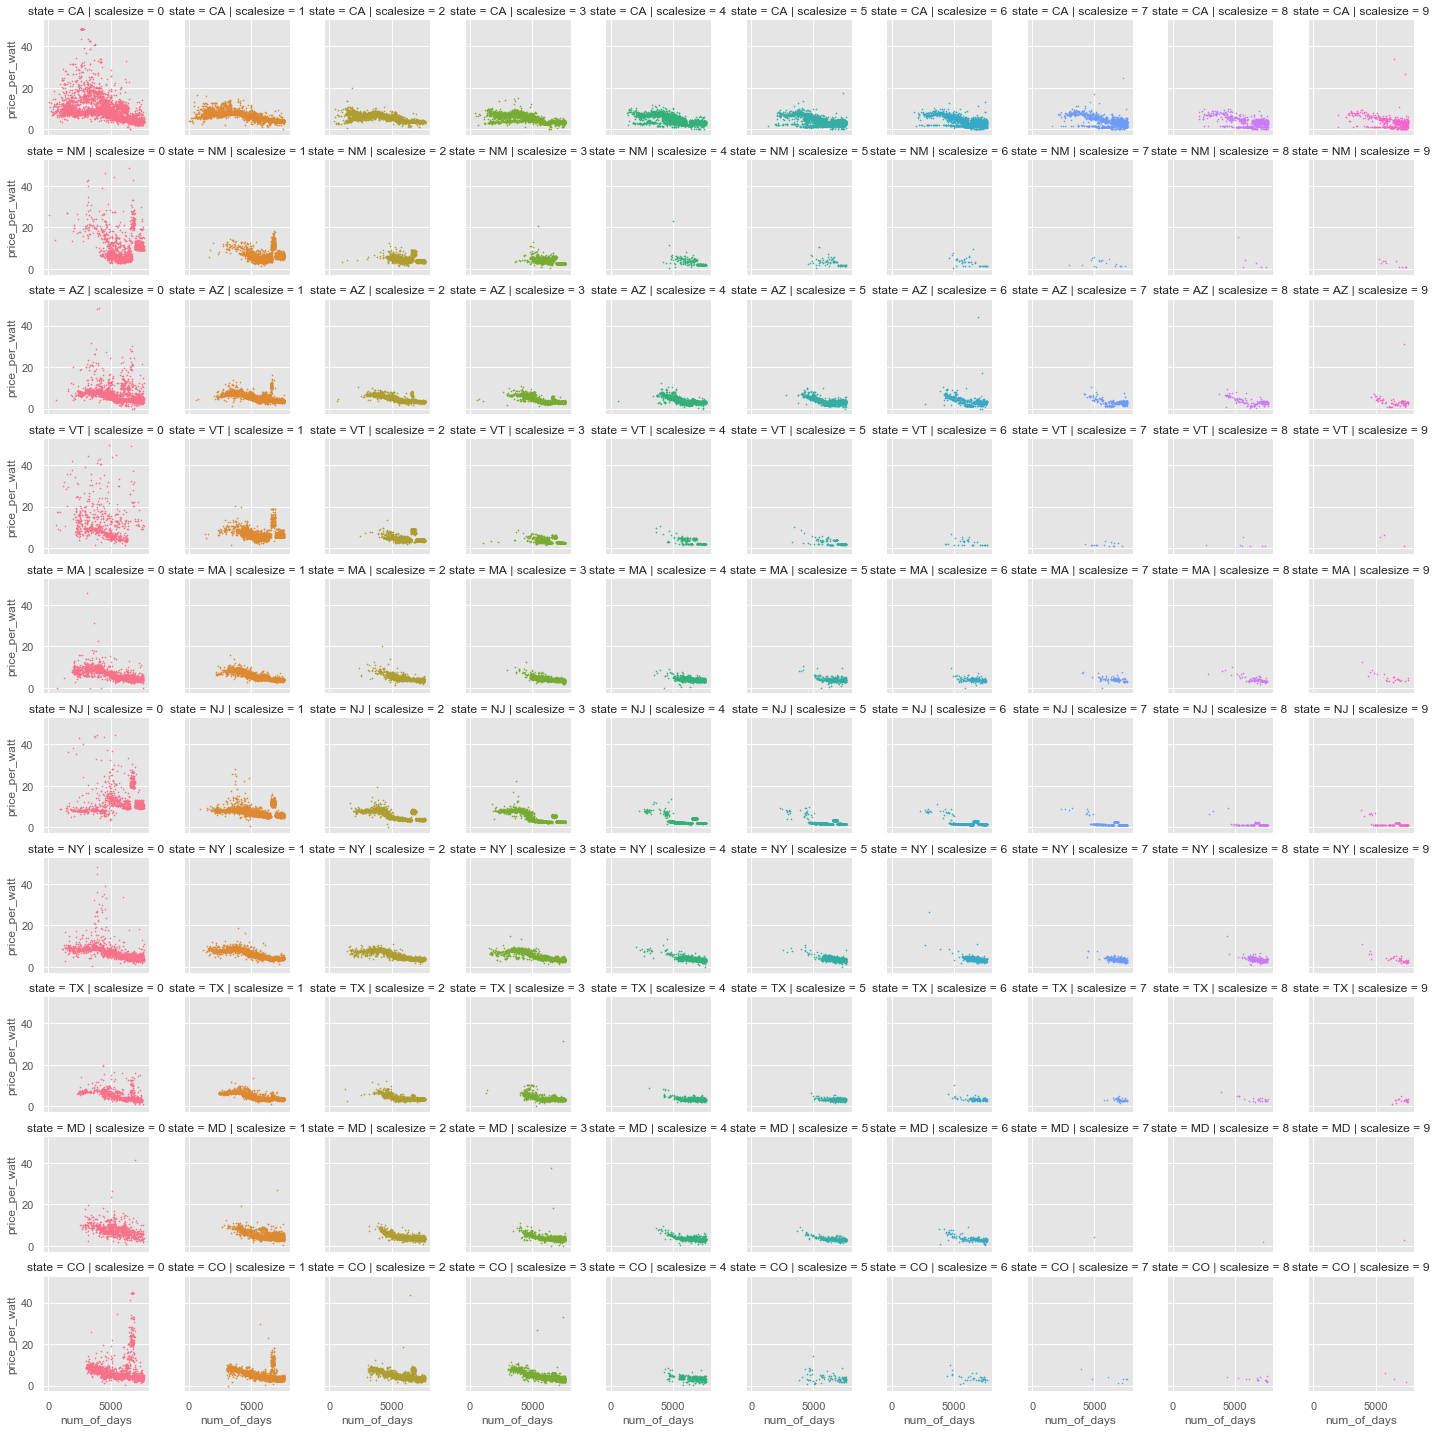

In [82]:
# per w    v.   time      in ten biggest states by size
g = sns.FacetGrid(dfMedByDay[dfMedByDay.state.isin(['CA', 'NJ', 'AZ', 'NY','MA','CO', 'TX', 'NM','MD','VT'])], 
                  col='scalesize', row='state', hue='scalesize', size=2)
g.map(plt.scatter, 'num_of_days', 'price_per_watt', marker='.', s=5);

In [83]:
dfModDay = pd.get_dummies(dfMedByDay, drop_first=True); dfModDay.head()

,num_of_days,scalesize,price_per_watt,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_KS,state_MA,state_MD,state_MN,state_MO,state_NH,state_NJ,state_NM,state_NY,state_OH,state_OR,state_PA,state_RI,state_TX,state_UT,state_VT,state_WI
0,0,1,3.97,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30,0,25.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,68,0,13.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,90,1,4.03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,102,0,29.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [84]:
X = dfModDay.drop(['price_per_watt'], axis='columns')
y = dfModDay[['price_per_watt']]

X.shape, y.shape

((140419, 26), (140419, 1))

In [85]:

X.iloc[0,:]

num_of_days    0
scalesize      1
state_AZ       0
state_CA       1
state_CO       0
state_CT       0
state_DC       0
state_DE       0
state_FL       0
state_KS       0
state_MA       0
state_MD       0
state_MN       0
state_MO       0
state_NH       0
state_NJ       0
state_NM       0
state_NY       0
state_OH       0
state_OR       0
state_PA       0
state_RI       0
state_TX       0
state_UT       0
state_VT       0
state_WI       0
Name: 0, dtype: int64

In [86]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [87]:
theStates = ['state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_KS', 'state_MA',
       'state_MD', 'state_MN', 'state_MO', 'state_NH', 'state_NJ', 'state_NM',
       'state_NY', 'state_OH', 'state_OR', 'state_PA', 'state_RI', 'state_TX',
       'state_UT', 'state_VT', 'state_WI']

In [88]:
pipeline = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_of_days', 'scalesize'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('LR', LinearRegression())
]) # end of Pipeline

In [89]:
pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'features', 'LR', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__verbose', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__num_vars__poly__order', 'features__cat_vars__columns', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])

In [90]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 10)
param_grid = {'features__num_vars__poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared', verbose=3)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
#r2# gs_cv.cv_results_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] features__num_vars__poly__degree=1 ..............................
[CV]  features__num_vars__poly__degree=1, RMSE=(train=-2.552, test=-2.538), Rsquared=(train=0.361, test=0.361), total=   0.1s
[CV] features__num_vars__poly__degree=1 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  features__num_vars__poly__degree=1, RMSE=(train=-2.575, test=-2.493), Rsquared=(train=0.359, test=0.364), total=   0.1s
[CV] features__num_vars__poly__degree=1 ..............................
[CV]  features__num_vars__poly__degree=1, RMSE=(train=-2.514, test=-2.613), Rsquared=(train=0.363, test=0.357), total=   0.1s
[CV] features__num_vars__poly__degree=2 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  features__num_vars__poly__degree=2, RMSE=(train=-2.487, test=-2.472), Rsquared=(train=0.393, test=0.394), total=   0.1s
[CV] features__num_vars__poly__degree=2 ..............................
[CV]  features__num_vars__poly__degree=2, RMSE=(train=-2.506, test=-2.433), Rsquared=(train=0.393, test=0.394), total=   0.1s
[CV] features__num_vars__poly__degree=2 ..............................
[CV]  features__num_vars__poly__degree=2, RMSE=(train=-2.451, test=-2.543), Rsquared=(train=0.395, test=0.391), total=   0.1s
[CV] features__num_vars__poly__degree=3 ..............................
[CV]  features__num_vars__poly__degree=3, RMSE=(train=-2.437, test=-2.421), Rsquared=(train=0.417, test=0.419), total=   0.1s
[CV] features__num_vars__poly__degree=3 ..............................
[CV]  features__num_vars__poly__degree=3, RMSE=(train=-2.456, test=-2.383), Rsquared=(train=0.417, test=0.419), total=   0.1s
[CV] features__num_vars__poly__degree=3 ..............................
[CV]  features_

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.5s finished


Best parameters: {'features__num_vars__poly__degree': 9}
test R squared: 0.43591389029354466


In [91]:
gs_cv.cv_results_['mean_test_RMSE'], gs_cv.cv_results_['mean_test_Rsquared']

(array([-2.54810597, -2.48241279, -2.43243046, -2.41834928, -2.38798562,
        -2.38228536, -2.37529622, -2.36738986, -2.36582927]),
 array([0.36050682, 0.39303361, 0.41724016, 0.42395767, 0.43833096,
        0.44100836, 0.44428166, 0.44798127, 0.44871109]))

Best parameters: {'features__num_vars__poly__degree': 9}
Best R squared: 0.43591389029354466


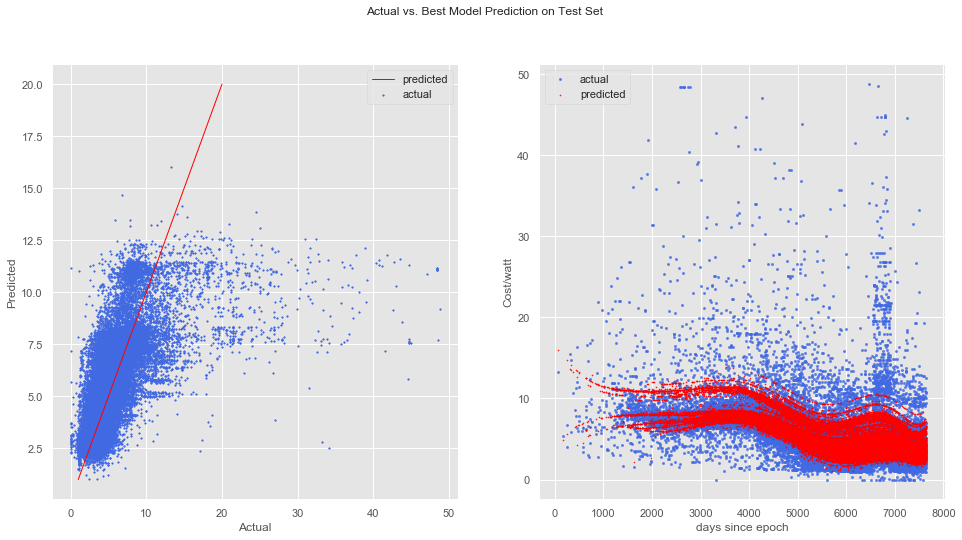

In [92]:
#show r2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test['num_of_days'], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test['num_of_days'], gs_cv.predict(X_test), marker='.', color='red', s=5, alpha=.8, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('days since epoch')
ax2.legend()

plt.show();

In [94]:
# the last day
X.iloc[-1,0]

7640

In [95]:
x1 = np.linspace(0.0, 7640, int(7640/91)); x1.shape
# set scaleSize 
x2 = np.zeros(82); x2[:] = 5.0
X_future = np.stack([x1, x2], axis=-1); X_future.shape

ValueError: all input arrays must have the same shape

In [96]:
dfModDay

,num_of_days,scalesize,price_per_watt,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_KS,state_MA,state_MD,state_MN,state_MO,state_NH,state_NJ,state_NM,state_NY,state_OH,state_OR,state_PA,state_RI,state_TX,state_UT,state_VT,state_WI
0,0,1,3.97,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30,0,25.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,68,0,13.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,90,1,4.03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,102,0,29.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140414,7640,5,3.39,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
140415,7640,5,2.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
140416,7640,5,1.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
140417,7640,6,3.39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
state_CA = np.zeros((82, 18)); state_CA.shape

(82, 18)

In [98]:
state_CA[:, 1] = 1.0; 

# show me a couple of rows
state_CA[:2,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [99]:
X_CA_s1 = np.concatenate([X_future, state_CA], axis=1); X_CA_s1.shape

NameError: name 'X_future' is not defined

In [ ]:
dfX_CA = pd.DataFrame(X_CA_s1, columns=['num_of_days', 'scalesize', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_KS', 'state_MA',
       'state_MD', 'state_MN', 'state_MO', 'state_NH', 'state_NJ', 'state_NM',
       'state_NY', 'state_OH', 'state_OR', 'state_PA', 'state_RI', 'state_TX',
       'state_UT', 'state_VT', 'state_WI' ])

In [ ]:
gs_cv.predict(dfX_CA).shape


In [100]:
pred_df = rdfMod.copy()

In [101]:
sorted(pred_df.columns)

['Additional module model',
 'Appraised Value Flag',
 'Azimuth #1',
 'Azimuth #2',
 'Azimuth #3',
 'BIPV Module #1',
 'BIPV Module #2',
 'BIPV Module #3',
 'Battery System',
 'City',
 'Customer Segment',
 'DC Optimizer',
 'Data Provider',
 'Feed-in Tariff (Annual Payment)',
 'Feed-in Tariff (Duration)',
 'Ground Mounted',
 'Install_Month',
 'Install_Year',
 'Installation Date',
 'Installer Name',
 'Inverter Loading Ratio',
 'Inverter Manufacturer #1',
 'Inverter Manufacturer #2',
 'Inverter Manufacturer #3',
 'Inverter Model #1',
 'Inverter Model #2',
 'Inverter Model #3',
 'Microinverter #1',
 'Microinverter #2',
 'Microinverter #3',
 'Module Efficiency #1',
 'Module Efficiency #2',
 'Module Efficiency #3',
 'Module Manufacturer #1',
 'Module Manufacturer #2',
 'Module Manufacturer #3',
 'Module Model #1',
 'Module Model #2',
 'Module Model #3',
 'Module Technology #1',
 'Module Technology #2',
 'Module Technology #3',
 'New Construction',
 'Num of Days',
 'Performance-Based Incentive

In [102]:
residential_df = rdfMod.copy()

In [103]:
az = residential_df.loc[(residential_df['Azimuth #1'] != -9999) & (residential_df['Azimuth #1'] != '-9999') & (residential_df['Azimuth #2'] != -9999) & (residential_df['Azimuth #2'] != '-9999') & (residential_df['Azimuth #3'] != -9999) & (residential_df['Azimuth #3'] != '-9999')]
print(az['Azimuth #1'].mean())
print(az['Azimuth #2'].mean())
print(az['Azimuth #3'].mean())
residential_df['Azimuth #1'].replace(-9999,    round(az['Azimuth #1'].mean(), 1), inplace=True)
residential_df['Azimuth #1'].replace('-9999',    round(az['Azimuth #1'].mean(), 1), inplace=True)
residential_df['Azimuth #2'].replace(-9999,    round(az['Azimuth #2'].mean(), 1), inplace=True)
residential_df['Azimuth #2'].replace('-9999',    round(az['Azimuth #2'].mean(), 1), inplace=True)
residential_df['Azimuth #3'].replace(-9999,    round(az['Azimuth #3'].mean(), 1), inplace=True)
residential_df['Azimuth #3'].replace('-9999',    round(az['Azimuth #3'].mean(), 1), inplace=True)
print('---------------')

tilt = residential_df.loc[(residential_df['Tilt #1'] != -9999) & (residential_df['Tilt #1'] != '-9999') & (residential_df['Tilt #2'] != -9999) & (residential_df['Tilt #2'] != '-9999') & (residential_df['Tilt #3'] != -9999) & (residential_df['Tilt #3'] != '-9999')]
print(tilt['Tilt #1'].mean())
print(tilt['Tilt #2'].mean())
print(tilt['Tilt #3'].mean())
residential_df['Tilt #1'].replace(-9999,    round(tilt['Tilt #1'].mean(), 1), inplace=True)
residential_df['Tilt #1'].replace('-9999',    round(tilt['Tilt #1'].mean(), 1), inplace=True)
residential_df['Tilt #2'].replace(-9999,    round(tilt['Tilt #2'].mean(), 1), inplace=True)
residential_df['Tilt #2'].replace('-9999',    round(tilt['Tilt #2'].mean(), 1), inplace=True)
residential_df['Tilt #3'].replace(-9999,    round(tilt['Tilt #3'].mean(), 1), inplace=True)
residential_df['Tilt #3'].replace('-9999',    round(tilt['Tilt #3'].mean(), 1), inplace=True)
print('---------------')
mod_eff = residential_df.loc[(residential_df['Module Efficiency #1'] != -9999) & (residential_df['Module Efficiency #1'] != '-9999') & (residential_df['Module Efficiency #2'] != -9999) & (residential_df['Module Efficiency #2'] != '-9999') & (residential_df['Module Efficiency #3'] != -9999) & (residential_df['Module Efficiency #3'] != '-9999')]
print(mod_eff['Module Efficiency #1'].mean())
print(mod_eff['Module Efficiency #2'].mean())
print(mod_eff['Module Efficiency #3'].mean())
residential_df['Module Efficiency #1'].replace(-9999,    round(mod_eff ['Module Efficiency #1'].mean(), 1), inplace=True)
residential_df['Module Efficiency #1'].replace('-9999',    round(mod_eff ['Module Efficiency #1'].mean(), 1), inplace=True)
residential_df['Module Efficiency #2'].replace(-9999,    round(mod_eff ['Module Efficiency #2'].mean(), 1), inplace=True)
residential_df['Module Efficiency #2'].replace('-9999',    round(mod_eff ['Module Efficiency #2'].mean(), 1), inplace=True)
residential_df['Module Efficiency #3'].replace(-9999,    round(mod_eff ['Module Efficiency #3'].mean(), 1), inplace=True)
residential_df['Module Efficiency #3'].replace('-9999',    round(mod_eff ['Module Efficiency #3'].mean(), 1), inplace=True)
print('---------------')

invload = residential_df.loc[(residential_df['Inverter Loading Ratio'] != -9999) &(residential_df['Inverter Loading Ratio'] != '-9999') ]
print(invload['Inverter Loading Ratio'].mean())
residential_df['Inverter Loading Ratio'].replace(-9999,    round(invload['Inverter Loading Ratio'].mean(), 2), inplace=True)
residential_df['Inverter Loading Ratio'].replace('-9999',    round(invload['Inverter Loading Ratio'].mean(), 2), inplace=True)

print('---------------')

# incent_ann = residential_df.loc[(residential_df['Performance-Based Incentive (Annual Payment)'] != -9999) & (residential_df['Performance-Based Incentive (Annual Payment)'] != '-9999')] 
# print(incent_ann['Performance-Based Incentive (Annual Payment)'].mean())                             
# residential_df['Performance-Based Incentive (Annual Payment)'].replace(-9999,    round(incent_ann['Performance-Based Incentive (Annual Payment)'].mean()), inplace=True)
# residential_df['Performance-Based Incentive (Annual Payment)'].replace('-9999',    round(incent_ann['Performance-Based Incentive (Annual Payment)'].mean()), inplace=True)
# print('---------------')


incent_dur = residential_df.loc[(residential_df['Performance-Based Incentives (Duration)'] != -9999) & (residential_df['Performance-Based Incentives (Duration)'] != '-9999')] 
print(incent_dur['Performance-Based Incentives (Duration)'].mean())                             
residential_df['Performance-Based Incentives (Duration)'].replace(-9999,    round(incent_dur['Performance-Based Incentives (Duration)'].mean()), inplace=True)
residential_df['Performance-Based Incentives (Duration)'].replace('-9999',    round(incent_dur['Performance-Based Incentives (Duration)'].mean()), inplace=True)
print('---------------')


# rebate = residential_df.loc[(residential_df['Rebate or Grant'] != -9999) & (residential_df['Rebate or Grant'] != '-9999')]            
# print(rebate['Rebate or Grant'].mean())
# residential_df['Rebate or Grant'].replace(-9999,    round(rebate['Inverter Loading Ratio'].mean()), inplace=True)
# residential_df['Rebate or Grant'].replace('-9999',    round(rebate['Inverter Loading Ratio'].mean()), inplace=True)

185.25581747638324
186.96491228070175
184.14244264507423
---------------
20.77903682719547
20.822946175637394
20.721165520032375
---------------
0.17377387309221787
0.1741142779032843
0.17392158528425172
---------------
1.2060426913681148
---------------
0.017634456118285693
---------------


In [104]:
residential_df

,Data Provider,System ID (from first Data Provider),"System ID (from second Data Provider, if applicable)",System ID (Tracking the Sun),Installation Date,System Size,Total Installed Price,Appraised Value Flag,Sales Tax Cost,Rebate or Grant,Performance-Based Incentive (Annual Payment),Performance-Based Incentives (Duration),Feed-in Tariff (Annual Payment),Feed-in Tariff (Duration),Customer Segment,New Construction,Tracking,Ground Mounted,Battery System,Zip Code,City,State,Utility Service Territory,Third-Party Owned,Installer Name,Self-Installed,Azimuth #1,Azimuth #2,Azimuth #3,Tilt #1,Tilt #2,Tilt #3,Module Manufacturer #1,Module Model #1,Module Manufacturer #2,Module Model #2,Module Manufacturer #3,Module Model #3,Additional module model,Module Technology #1,Module Technology #2,Module Technology #3,BIPV Module #1,BIPV Module #2,BIPV Module #3,Module Efficiency #1,Module Efficiency #2,Module Efficiency #3,Inverter Manufacturer #1,Inverter Manufacturer #2,Inverter Manufacturer #3,Inverter Model #1,Inverter Model #2,Inverter Model #3,Microinverter #1,Microinverter #2,Microinverter #3,System Inverter Capacity,DC Optimizer,Inverter Loading Ratio,Install_Month,Install_Year,Num of Days,Price per Watt,scaleSize
0,California Public Utilities Commission,PGE-INT-113274013,-9999,CA_H7eLVHHEes,1998-01-30,4.2515,16858.89,False,-9999.000000,-9999.0,0.0,0,0.0,0,RES,0,-9999,-9999,0,95949,Nevada City,CA,Pacific Gas and Electric,0,-9999,0,185.3,187.0,184.1,20.8,20.8,20.7,-9999,no match,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,-9999,-9999,0.200000,0.2,0.2,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.000,0,1.210000,1998-01,1998,0,3.97,1
1,Public Service Company of New Mexico,Qfs<10kW #1,-9999,NM_4qvdvVIwOc,1998-03-01,0.6500,16858.89,False,-9999.000000,-9999.0,0.0,0,0.0,0,RES,-9999,-9999,-9999,-9999,87109,ALBUQUERQUE,NM,Public Service Company of New Mexico,-9999,-9999,-9999,185.3,187.0,184.1,20.8,20.8,20.7,-9999,no match,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,0.200000,0.2,0.2,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.000,0,1.210000,1998-03,1998,30,25.94,0
2,California Public Utilities Commission & Calif...,PGE-INT-113274187,3,CA_CSGUecqKc4,1998-04-08,2.3316,30941.00,False,-9999.000000,5829.0,0.0,0,0.0,0,RES,0,-9999,-9999,0,94038,Moss Beach,CA,Pacific Gas and Electric,0,solar selfcal help,0,185.3,187.0,184.1,20.8,20.8,20.7,Sharp,-9999,-9999,-9999,-9999,-9999,0,Poly,-9999,-9999,0,-9999,-9999,0.200000,0.2,0.2,Fronius USA,-9999,-9999,-9999,-9999,-9999,0,-9999,-9999,4.000,0,0.582900,1998-04,1998,68,13.27,0
3,California Public Utilities Commission,PGE-INT-113274195,-9999,CA_LUx6pBg5MW,1998-04-30,4.1811,16858.89,False,-9999.000000,-9999.0,0.0,0,0.0,0,RES,0,-9999,-9999,0,94563,Orinda,CA,Pacific Gas and Electric,0,-9999,0,185.3,187.0,184.1,20.8,20.8,20.7,-9999,no match,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,-9999,-9999,0.200000,0.2,0.2,Schneider Electric,-9999,-9999,-9999,-9999,-9999,0,-9999,-9999,3.211,0,1.302118,1998-04,1998,90,4.03,1
4,Oregon Department of Energy,743229,-9999,OR_G3YD6VpD98,1998-05-12,0.6000,17439.00,False,-9999.000000,-9999.0,0.0,0,0.0,0,RES,-9999,-9999,-9999,-9999,97064,Vernonia,OR,-9999,0,gen con,0,185.3,187.0,184.1,20.8,20.8,20.7,-9999,no match,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,0.200000,0.2,0.2,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.000,0,1.210000,1998-05,1998,102,29.06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065994,UniSource Energy Services,UNSEDG-02003,-9999,AZ_1efeixOT7j,2018-12-31,7.2000,29952.00,False,0.000000,0.0,0.0,0,0.0,0,RES,-9999,-9999,-9999,-9999,85648,-9999,AZ,UniSource Energy Services,-9999,solar solution az,0,185.3,187.0,184.1,20.8,20.8,20.7,-9999,no match,-9999,-99

In [105]:
residential_df['Module Technology #1'].replace(-9999, 'Unknown' , inplace=True)
residential_df['Module Technology #1'].replace('-9999', 'Unknown' , inplace=True)
residential_df['Module Technology #2'].replace(-9999, 'Unknown' , inplace=True)
residential_df['Module Technology #2'].replace('-9999', 'Unknown' , inplace=True)
residential_df['Module Technology #3'].replace(-9999, 'Unknown' , inplace=True)
residential_df['Module Technology #3'].replace('-9999', 'Unknown' , inplace=True)

In [106]:
modtech3 = pd.get_dummies(residential_df, columns= ['Module Technology #3'])
modtech3 = modtech3[['Module Technology #3_CIGS' , 'Module Technology #3_Mono' , 'Module Technology #3_Mono + a-Si' , 'Module Technology #3_Poly' , 'Module Technology #3_Thin Film' , 'Module Technology #3_Unknown' , 'Module Technology #3_a-Si' , 'Module Technology #3_crystalline' , 'Module Technology #3_multiple']]
modtech3.columns=modtech3.columns.str.replace('Module Technology #3_','')

modtech2 = pd.get_dummies(residential_df, columns= ['Module Technology #2'])
modtech2 = modtech2[['Module Technology #2_CIGS' , 'Module Technology #2_Mono' , 'Module Technology #2_Mono + a-Si' , 'Module Technology #2_Poly' , 'Module Technology #2_Thin Film' , 'Module Technology #2_Unknown' , 'Module Technology #2_a-Si' , 'Module Technology #2_crystalline' , 'Module Technology #2_multiple']]
modtech2.columns=modtech2.columns.str.replace('Module Technology #2_','')

modtech1 = pd.get_dummies(residential_df, columns= ['Module Technology #1'])
modtech1 = modtech1[['Module Technology #1_CIGS' , 'Module Technology #1_Mono' , 'Module Technology #1_Mono + a-Si' , 'Module Technology #1_Poly' , 'Module Technology #1_Thin Film' , 'Module Technology #1_Unknown' , 'Module Technology #1_a-Si' , 'Module Technology #1_crystalline' , 'Module Technology #1_multiple']]
modtech1.columns=modtech1.columns.str.replace('Module Technology #1_','')

modtech = modtech1 + modtech2 + modtech3
modtech.drop(columns='Unknown', inplace=True)

for i in modtech.columns:
    residential_df[i] = modtech[i]

In [107]:
sorted(residential_df['Inverter Loading Ratio'].unique())

[0.000278873,
 0.000578947,
 0.000671429,
 0.0009156,
 0.0009199999999999999,
 0.001096681,
 0.0011530610000000001,
 0.001162791,
 0.00118125,
 0.001210526,
 0.0012375,
 0.001268367,
 0.001443001,
 0.001521134,
 0.001750842,
 0.0019240020000000002,
 0.002,
 0.0024,
 0.003,
 0.003975469000000001,
 0.006403162,
 0.008,
 0.008168168,
 0.00912,
 0.009684211,
 0.010252525,
 0.011041667,
 0.011381381000000001,
 0.011458333000000001,
 0.01161512,
 0.011666667,
 0.013181546,
 0.013395348999999999,
 0.013999999999999999,
 0.015418605,
 0.01568,
 0.016,
 0.016604651,
 0.018000000000000002,
 0.018139535,
 0.01824,
 0.018748963,
 0.020614035,
 0.021929825,
 0.022341568,
 0.022404719,
 0.022807018,
 0.023245613999999998,
 0.023423423,
 0.024122807000000003,
 0.024186047000000002,
 0.024242424,
 0.024888888999999997,
 0.024989879,
 0.025,
 0.025041736000000002,
 0.025438596,
 0.0255,
 0.025792159,
 0.026000000000000002,
 0.026162791,
 0.026303827999999998,
 0.026315789,
 0.0265,
 0.02667165799999999

In [108]:
residential_df = residential_df[['Installation Date', 'System Size', 'Total Installed Price', 'State','Module Efficiency #1','Module Efficiency #2','Module Efficiency #3', 'Inverter Loading Ratio' , 'Install_Month' , 'Install_Year' , 'Num of Days' , 'Price per Watt' , 'scaleSize' , 'CIGS' , 'Mono' , 'Mono + a-Si' , 'Poly' , 'Thin Film' , 'a-Si' , 'crystalline' , 'multiple' ]]

In [109]:
residential_df['module_efficiency'] = round((residential_df['Module Efficiency #1'] + residential_df['Module Efficiency #2'] + residential_df['Module Efficiency #3'])/3,2)

In [110]:
residential_df.drop(columns=['Module Efficiency #1', 'Module Efficiency #2', 'Module Efficiency #3'], inplace=True)

In [111]:
resdf = residential_df.copy()

In [112]:
resdf['System Size'] = round(resdf['System Size'],2)

In [114]:
resdf.columns = resdf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

Text(0.5, 1.0, 'Price per watt')

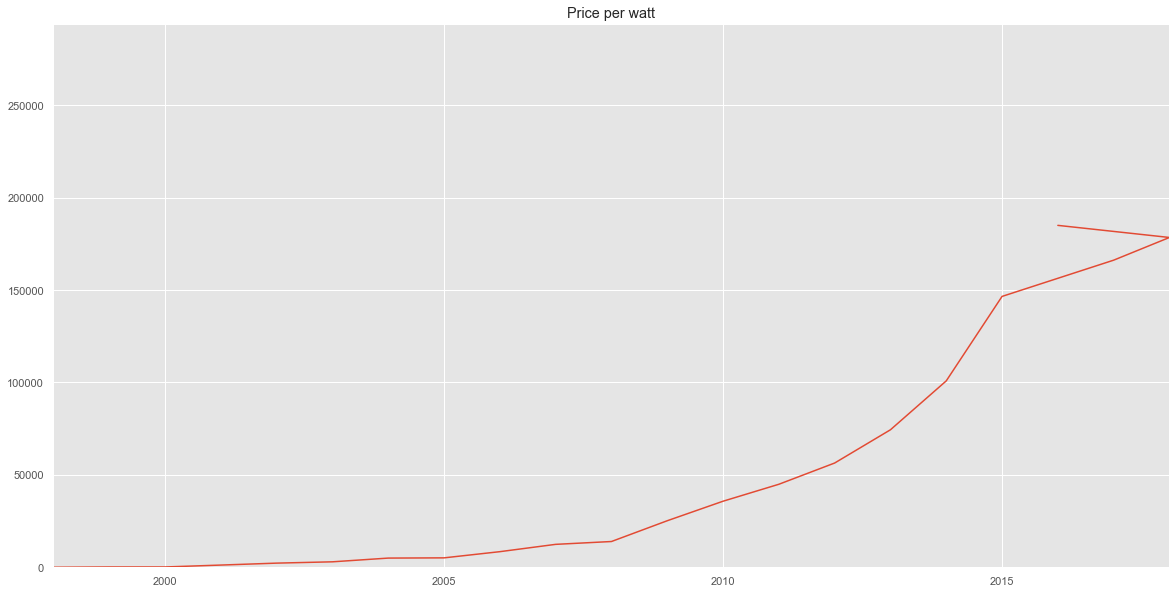

In [115]:
resdf.install_year.value_counts().plot(title =("Installations per Year") , figsize=(20,10))

resdf.price_per_watt.hist(bins=50)
plt.title('Price per watt')

In [116]:
#quick pivot to see price per watt by state and installation date
pivot = resdf.pivot_table(index=[resdf.index], columns=['state'], values=['price_per_watt'])

Text(0.5, 1.0, 'Price per watt by state and installation date')

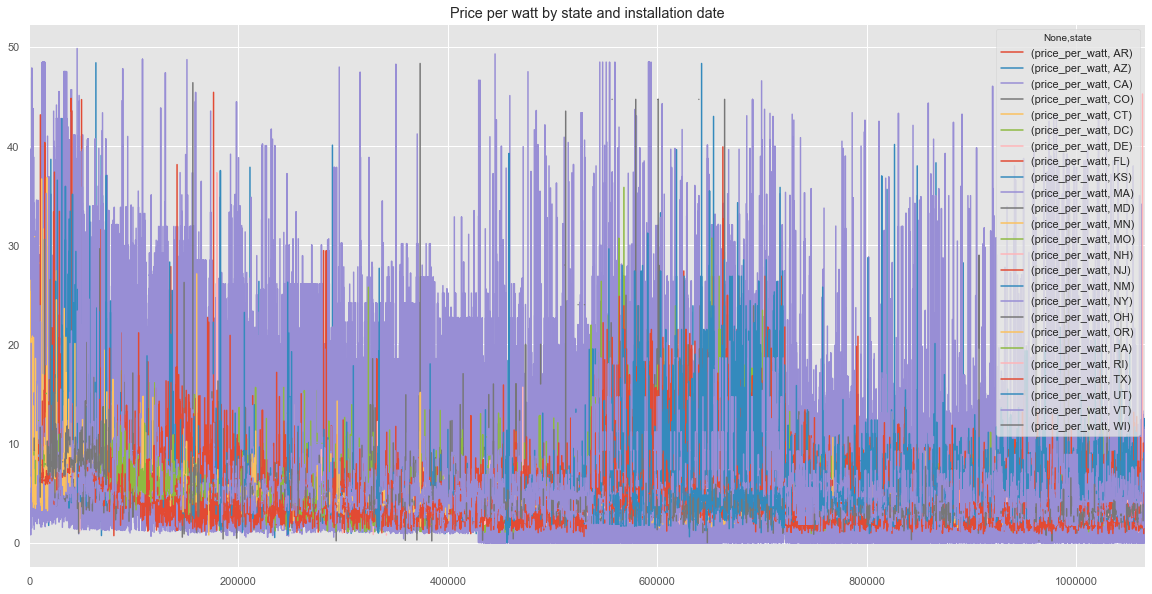

In [117]:
pivot.plot(figsize=(20,10))
plt.title('Price per watt by state and installation date')

min 0.08
max 39.98
median 5.94
mean 6.58

In [118]:
alot.set_index(['installation_date'], drop=True, inplace=True)

In [ ]:
resdf

In [128]:
small = resdf[['price_per_watt', 'install_month']]

In [129]:
small

,price_per_watt,install_month
installation_date,,
1998-01-30,3.97,1998-01
1998-03-01,25.94,1998-03
1998-04-08,13.27,1998-04
1998-04-30,4.03,1998-04
1998-05-12,29.06,1998-05
...,...,...
2018-12-31,4.16,2018-12
2018-12-31,5.96,2018-12
2018-12-31,2.90,2018-12


In [130]:
small

,price_per_watt,install_month
installation_date,,
1998-01-30,3.97,1998-01
1998-03-01,25.94,1998-03
1998-04-08,13.27,1998-04
1998-04-30,4.03,1998-04
1998-05-12,29.06,1998-05
...,...,...
2018-12-31,4.16,2018-12
2018-12-31,5.96,2018-12
2018-12-31,2.90,2018-12


In [139]:
avg_per_month = small.groupby('install_month').mean()

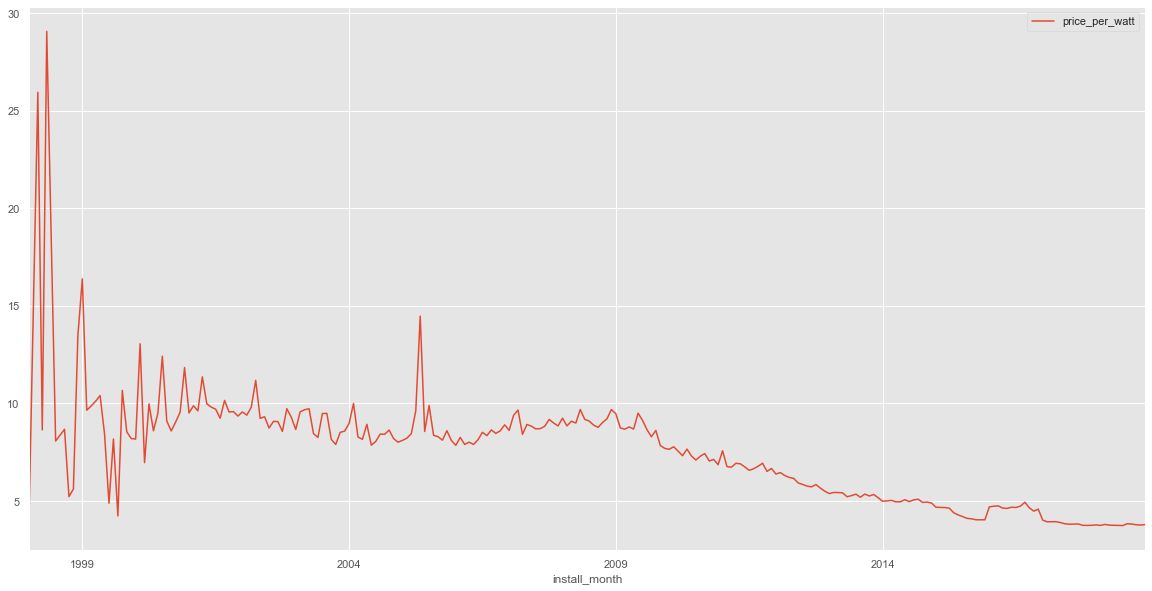

In [142]:
avg_per_month.plot(figsize=(20,10))

In [131]:
m1 = small.loc[small.install_month=='1998-01']
m3 = small.loc[small.install_month=='1998-03']
m4 = small.loc[small.install_month=='1998-04']
m5 = small.loc[small.install_month=='1998-05']
m7 = small.loc[small.install_month=='1998-07']
m9 = small.loc[small.install_month=='1998-09']
m10 = small.loc[small.install_month=='1998-10']
m11 = small.loc[small.install_month=='1998-11']
m12 = small.loc[small.install_month=='1998-12']
m13 = small.loc[small.install_month=='1999-01']
m14 = small.loc[small.install_month=='1999-02']
m15 = small.loc[small.install_month=='1999-03']
m16 = small.loc[small.install_month=='1999-04']
m17 = small.loc[small.install_month=='1999-05']
m18 = small.loc[small.install_month=='1999-06']
m19 = small.loc[small.install_month=='1999-07']
m20 = small.loc[small.install_month=='1999-08']
m21 = small.loc[small.install_month=='1999-09']
m22 = small.loc[small.install_month=='1999-10']
m23 = small.loc[small.install_month=='1999-11']
m24 = small.loc[small.install_month=='1999-12']
m25 = small.loc[small.install_month=='2000-01']
m26 = small.loc[small.install_month=='2000-02']
m27 = small.loc[small.install_month=='2000-03']
m28 = small.loc[small.install_month=='2000-04']
m29 = small.loc[small.install_month=='2000-05']
m30 = small.loc[small.install_month=='2000-06']
m31 = small.loc[small.install_month=='2000-07']
m32 = small.loc[small.install_month=='2000-08']
m33 = small.loc[small.install_month=='2000-09']
m34 = small.loc[small.install_month=='2000-10']
m35 = small.loc[small.install_month=='2000-11']
m36 = small.loc[small.install_month=='2000-12']
m37 = small.loc[small.install_month=='2001-01']
m38 = small.loc[small.install_month=='2001-02']
m39 = small.loc[small.install_month=='2001-03']
m40 = small.loc[small.install_month=='2001-04']
m41 = small.loc[small.install_month=='2001-05']
m42 = small.loc[small.install_month=='2001-06']
m43 = small.loc[small.install_month=='2001-07']
m44 = small.loc[small.install_month=='2001-08']
m45 = small.loc[small.install_month=='2001-09']
m46 = small.loc[small.install_month=='2001-10']
m47 = small.loc[small.install_month=='2001-11']
m48 = small.loc[small.install_month=='2001-12']
m49 = small.loc[small.install_month=='2002-01']
m50 = small.loc[small.install_month=='2002-02']
m51 = small.loc[small.install_month=='2002-03']
m52 = small.loc[small.install_month=='2002-04']
m53 = small.loc[small.install_month=='2002-05']
m54 = small.loc[small.install_month=='2002-06']
m55 = small.loc[small.install_month=='2002-07']
m56 = small.loc[small.install_month=='2002-08']
m57 = small.loc[small.install_month=='2002-09']
m58 = small.loc[small.install_month=='2002-10']
m59 = small.loc[small.install_month=='2002-11']
m60 = small.loc[small.install_month=='2002-12']
m61 = small.loc[small.install_month=='2003-01']
m62 = small.loc[small.install_month=='2003-02']
m63 = small.loc[small.install_month=='2003-03']
m64 = small.loc[small.install_month=='2003-04']
m65 = small.loc[small.install_month=='2003-05']
m66 = small.loc[small.install_month=='2003-06']
m67 = small.loc[small.install_month=='2003-07']
m68 = small.loc[small.install_month=='2003-08']
m69 = small.loc[small.install_month=='2003-09']
m70 = small.loc[small.install_month=='2003-10']
m71 = small.loc[small.install_month=='2003-11']
m72 = small.loc[small.install_month=='2003-12']
m73 = small.loc[small.install_month=='2004-01']
m74 = small.loc[small.install_month=='2004-02']
m75 = small.loc[small.install_month=='2004-03']
m76 = small.loc[small.install_month=='2004-04']
m77 = small.loc[small.install_month=='2004-05']
m78 = small.loc[small.install_month=='2004-06']
m79 = small.loc[small.install_month=='2004-07']
m80 = small.loc[small.install_month=='2004-08']
m81 = small.loc[small.install_month=='2004-09']
m82 = small.loc[small.install_month=='2004-10']
m83 = small.loc[small.install_month=='2004-11']
m84 = small.loc[small.install_month=='2004-12']
m85 = small.loc[small.install_month=='2005-01']
m86 = small.loc[small.install_month=='2005-02']
m87 = small.loc[small.install_month=='2005-03']
m88 = small.loc[small.install_month=='2005-04']
m89 = small.loc[small.install_month=='2005-05']
m90 = small.loc[small.install_month=='2005-06']
m91 = small.loc[small.install_month=='2005-07']
m92 = small.loc[small.install_month=='2005-08']
m93 = small.loc[small.install_month=='2005-09']
m94 = small.loc[small.install_month=='2005-10']
m95 = small.loc[small.install_month=='2005-11']
m96 = small.loc[small.install_month=='2005-12']
m97 = small.loc[small.install_month=='2006-01']
m98 = small.loc[small.install_month=='2006-02']
m99 = small.loc[small.install_month=='2006-03']
m100 = small.loc[small.install_month=='2006-04']
m101 = small.loc[small.install_month=='2006-05']
m102 = small.loc[small.install_month=='2006-06']
m103 = small.loc[small.install_month=='2006-07']
m104 = small.loc[small.install_month=='2006-08']
m105 = small.loc[small.install_month=='2006-09']
m106 = small.loc[small.install_month=='2006-10']
m107 = small.loc[small.install_month=='2006-11']
m108 = small.loc[small.install_month=='2006-12']
m109 = small.loc[small.install_month=='2007-01']
m110 = small.loc[small.install_month=='2007-02']
m111 = small.loc[small.install_month=='2007-03']
m112 = small.loc[small.install_month=='2007-04']
m113 = small.loc[small.install_month=='2007-05']
m114 = small.loc[small.install_month=='2007-06']
m115 = small.loc[small.install_month=='2007-07']
m116 = small.loc[small.install_month=='2007-08']
m117 = small.loc[small.install_month=='2007-09']
m118 = small.loc[small.install_month=='2007-10']
m119 = small.loc[small.install_month=='2007-11']
m120 = small.loc[small.install_month=='2007-12']
m121 = small.loc[small.install_month=='2008-01']
m122 = small.loc[small.install_month=='2008-02']
m123 = small.loc[small.install_month=='2008-03']
m124 = small.loc[small.install_month=='2008-04']
m125 = small.loc[small.install_month=='2008-05']
m126 = small.loc[small.install_month=='2008-06']
m127 = small.loc[small.install_month=='2008-07']
m128 = small.loc[small.install_month=='2008-08']
m129 = small.loc[small.install_month=='2008-09']
m130 = small.loc[small.install_month=='2008-10']
m131 = small.loc[small.install_month=='2008-11']
m132 = small.loc[small.install_month=='2008-12']
m133 = small.loc[small.install_month=='2009-01']
m134 = small.loc[small.install_month=='2009-02']
m135 = small.loc[small.install_month=='2009-03']
m136 = small.loc[small.install_month=='2009-04']
m137 = small.loc[small.install_month=='2009-05']
m138 = small.loc[small.install_month=='2009-06']
m139 = small.loc[small.install_month=='2009-07']
m140 = small.loc[small.install_month=='2009-08']
m141 = small.loc[small.install_month=='2009-09']
m142 = small.loc[small.install_month=='2009-10']
m143 = small.loc[small.install_month=='2009-11']
m144 = small.loc[small.install_month=='2009-12']
m145 = small.loc[small.install_month=='2010-01']
m146 = small.loc[small.install_month=='2010-02']
m147 = small.loc[small.install_month=='2010-03']
m148 = small.loc[small.install_month=='2010-04']
m149 = small.loc[small.install_month=='2010-05']
m150 = small.loc[small.install_month=='2010-06']
m151 = small.loc[small.install_month=='2010-07']
m152 = small.loc[small.install_month=='2010-08']
m153 = small.loc[small.install_month=='2010-09']
m154 = small.loc[small.install_month=='2010-10']
m155 = small.loc[small.install_month=='2010-11']
m156 = small.loc[small.install_month=='2010-12']
m157 = small.loc[small.install_month=='2011-01']
m158 = small.loc[small.install_month=='2011-02']
m159 = small.loc[small.install_month=='2011-03']
m160 = small.loc[small.install_month=='2011-04']
m161 = small.loc[small.install_month=='2011-05']
m162 = small.loc[small.install_month=='2011-06']
m163 = small.loc[small.install_month=='2011-07']
m164 = small.loc[small.install_month=='2011-08']
m165 = small.loc[small.install_month=='2011-09']
m166 = small.loc[small.install_month=='2011-10']
m167 = small.loc[small.install_month=='2011-11']
m168 = small.loc[small.install_month=='2011-12']
m169 = small.loc[small.install_month=='2012-01']
m170 = small.loc[small.install_month=='2012-02']
m171 = small.loc[small.install_month=='2012-03']
m172 = small.loc[small.install_month=='2012-04']
m173 = small.loc[small.install_month=='2012-05']
m174 = small.loc[small.install_month=='2012-06']
m175 = small.loc[small.install_month=='2012-07']
m176 = small.loc[small.install_month=='2012-08']
m177 = small.loc[small.install_month=='2012-09']
m178 = small.loc[small.install_month=='2012-10']
m179 = small.loc[small.install_month=='2012-11']
m180 = small.loc[small.install_month=='2012-12']
m181 = small.loc[small.install_month=='2013-01']
m182 = small.loc[small.install_month=='2013-02']
m183 = small.loc[small.install_month=='2013-03']
m184 = small.loc[small.install_month=='2013-04']
m185 = small.loc[small.install_month=='2013-05']
m186 = small.loc[small.install_month=='2013-06']
m187 = small.loc[small.install_month=='2013-07']
m188 = small.loc[small.install_month=='2013-08']
m189 = small.loc[small.install_month=='2013-09']
m190 = small.loc[small.install_month=='2013-10']
m191 = small.loc[small.install_month=='2013-11']
m192 = small.loc[small.install_month=='2013-12']
m193 = small.loc[small.install_month=='2014-01']
m194 = small.loc[small.install_month=='2014-02']
m195 = small.loc[small.install_month=='2014-03']
m196 = small.loc[small.install_month=='2014-04']
m197 = small.loc[small.install_month=='2014-05']
m198 = small.loc[small.install_month=='2014-06']
m199 = small.loc[small.install_month=='2014-07']
m200 = small.loc[small.install_month=='2014-08']
m201 = small.loc[small.install_month=='2014-09']
m202 = small.loc[small.install_month=='2014-10']
m203 = small.loc[small.install_month=='2014-11']
m204 = small.loc[small.install_month=='2014-12']
m205 = small.loc[small.install_month=='2015-01']
m206 = small.loc[small.install_month=='2015-02']
m207 = small.loc[small.install_month=='2015-03']
m208 = small.loc[small.install_month=='2015-04']
m209 = small.loc[small.install_month=='2015-05']
m210 = small.loc[small.install_month=='2015-06']
m211 = small.loc[small.install_month=='2015-07']
m212 = small.loc[small.install_month=='2015-08']
m213 = small.loc[small.install_month=='2015-09']
m214 = small.loc[small.install_month=='2015-10']
m215 = small.loc[small.install_month=='2015-11']
m216 = small.loc[small.install_month=='2015-12']
m217 = small.loc[small.install_month=='2016-01']
m218 = small.loc[small.install_month=='2016-02']
m219 = small.loc[small.install_month=='2016-03']
m220 = small.loc[small.install_month=='2016-04']
m221 = small.loc[small.install_month=='2016-05']
m222 = small.loc[small.install_month=='2016-06']
m223 = small.loc[small.install_month=='2016-07']
m224 = small.loc[small.install_month=='2016-08']
m225 = small.loc[small.install_month=='2016-09']
m226 = small.loc[small.install_month=='2016-10']
m227 = small.loc[small.install_month=='2016-11']
m228 = small.loc[small.install_month=='2016-12']
m229 = small.loc[small.install_month=='2017-01']
m230 = small.loc[small.install_month=='2017-02']
m231 = small.loc[small.install_month=='2017-03']
m232 = small.loc[small.install_month=='2017-04']
m233 = small.loc[small.install_month=='2017-05']
m234 = small.loc[small.install_month=='2017-06']
m235 = small.loc[small.install_month=='2017-07']
m236 = small.loc[small.install_month=='2017-08']
m237 = small.loc[small.install_month=='2017-09']
m238 = small.loc[small.install_month=='2017-10']
m239 = small.loc[small.install_month=='2017-11']
m240 = small.loc[small.install_month=='2017-12']
m241 = small.loc[small.install_month=='2018-01']
m242 = small.loc[small.install_month=='2018-02']
m243 = small.loc[small.install_month=='2018-03']
m244 = small.loc[small.install_month=='2018-04']
m245 = small.loc[small.install_month=='2018-05']
m246 = small.loc[small.install_month=='2018-06']
m247 = small.loc[small.install_month=='2018-07']
m248 = small.loc[small.install_month=='2018-08']
m249 = small.loc[small.install_month=='2018-09']
m250 = small.loc[small.install_month=='2018-10']
m251 = small.loc[small.install_month=='2018-11']
m252 = small.loc[small.install_month=='2018-12']


In [132]:
#make a list of the month dfs for easy iteration
months = [m1
, m3
, m4
, m5
, m7
, m9
, m10
, m11
, m12
, m13
, m14
, m15
, m16
, m17
, m18
, m19
, m20
, m21
, m22
, m23
, m24
, m25
, m26
, m27
, m28
, m29
, m30
, m31
, m32
, m33
, m34
, m35
, m36
, m37
, m38
, m39
, m40
, m41
, m42
, m43
, m44
, m45
, m46
, m47
, m48
, m49
, m50
, m51
, m52
, m53
, m54
, m55
, m56
, m57
, m58
, m59
, m60
, m61
, m62
, m63
, m64
, m65
, m66
, m67
, m68
, m69
, m70
, m71
, m72
, m73
, m74
, m75
, m76
, m77
, m78
, m79
, m80
, m81
, m82
, m83
, m84
, m85
, m86
, m87
, m88
, m89
, m90
, m91
, m92
, m93
, m94
, m95
, m96
, m97
, m98
, m99
, m100
, m101
, m102
, m103
, m104
, m105
, m106
, m107
, m108
, m109
, m110
, m111
, m112
, m113
, m114
, m115
, m116
, m117
, m118
, m119
, m120
, m121
, m122
, m123
, m124
, m125
, m126
, m127
, m128
, m129
, m130
, m131
, m132
, m133
, m134
, m135
, m136
, m137
, m138
, m139
, m140
, m141
, m142
, m143
, m144
, m145
, m146
, m147
, m148
, m149
, m150
, m151
, m152
, m153
, m154
, m155
, m156
, m157
, m158
, m159
, m160
, m161
, m162
, m163
, m164
, m165
, m166
, m167
, m168
, m169
, m170
, m171
, m172
, m173
, m174
, m175
, m176
, m177
, m178
, m179
, m180
, m181
, m182
, m183
, m184
, m185
, m186
, m187
, m188
, m189
, m190
, m191
, m192
, m193
, m194
, m195
, m196
, m197
, m198
, m199
, m200
, m201
, m202
, m203
, m204
, m205
, m206
, m207
, m208
, m209
, m210
, m211
, m212
, m213
, m214
, m215
, m216
, m217
, m218
, m219
, m220
, m221
, m222
, m223
, m224
, m225
, m226
, m227
, m228
, m229
, m230
, m231
, m232
, m233
, m234
, m235
, m236
, m237
, m238
, m239
, m240
, m241
, m242
, m243
, m244
, m245
, m246
, m247
, m248
, m249
, m250
, m251
, m252]

In [135]:
for i in months:
    i.drop(columns=['install_month'], inplace=True)

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

In [ ]:
for i in range(1,241):
    print("'m%d = small.loc.install_month==',"%(i))

In [ ]:
for i in range(1,253):
    print('m%d'%(i))

In [ ]:
months

In [ ]:
def get_x_y(df):
    y = small[['price_per_watt']]
    X = small.drop(['price_per_watt',], axis=1)
    return X, y

In [ ]:
X, y = get_x_y(small)

In [ ]:
columns = X.columns

In [ ]:
fig, ax = plt.subplots(len(columns),1, figsize=(10,300))
for i, col in enumerate(columns):
    ax[i].scatter(X, y)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('price per w')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
rf_base = RandomForestRegressor()
rf_base.fit(X_train,y_train)
rf_base.score(X_test,y_test)

In [ ]:
rf_base_predict = rf_base.predict(X)

In [ ]:
fig, ax = plt.subplots(len(columns),1, figsize=(10,300))
for i, col in enumerate(columns):
    ax[i].scatter(X[col], y)
    aaax[i].scatter(X[col], rf_base_predict)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('price per W')

In [ ]:
final = small.copy()

final['rf_base_predict'] = rf_base_predict
final['rf_base_predict-actual'] = final['rf_base_predict'] - final['price_per_watt']


In [ ]:
final

In [ ]:
moving_avg = np.convolve( array_like, np.ones((10,))/10, mode='valid')

In [ ]:
dfModDay

In [ ]:
dfMod = dfMod[['num_days', 'size_kw', 'state', 'cost_per_watt', 'install_date']]

In [ ]:
# # only direct owership
# rdfMod = rdfMod[rdfMod['Third-Party Owned'] != 1]
# print(len(rdfMod))

#no battery modules as these are not typical pricing 
# rdfMod = rdfMod[rdfMod['Battery System'] != 1]
# print(len(rdfMod))

# plt.Line2D(rdfMod['install_month'],rdfMod['Third-Party Owned'])

In [ ]:
Installed Price Trends over Time

Module Efficiency Trends over Time

System Size over Time

annual change in median price

Installed Price, Module Price Index, Inverter Price Index, and Residual Costs over Time
State/Utility Rebates and PBIs over Time

Installed Price Differences Based on Module Efficiency

Figure 33. State Fixed-Effects from Regression Analysis Compared to Descriptive Analysis